In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
data = pd.read_csv('train.csv')
l = len(data)
data = data.dropna()
print(l-len(data),'null values dropped from data')

# Need to encode string values in weekday and department description fields for the classifier
descEnc = preprocessing.LabelEncoder()
descEnc.fit(data.DepartmentDescription.tolist())
dayEnc = preprocessing.LabelEncoder()
dayEnc.fit(data.Weekday.tolist())

data['EncodedDescription'] = pd.Series(descEnc.transform(data.DepartmentDescription.tolist()), index=data.index)
data['EncodedDay'] = pd.Series(dayEnc.transform(data.Weekday.tolist()), index=data.index)

train_dat = data.sample(10000)
test_dat = data.sample(1000)

In [ ]:
feature_columns = ['EncodedDay','EncodedDescription', 'Upc', 'ScanCount', 'FinelineNumber']
clf = svm.LinearSVC()

In [ ]:
print('Train the classifier')
clf.fit(train_dat[feature_columns], train_dat.TripType)

In [ ]:
clf.score(test_dat[feature_columns], test_dat.TripType)

In [ ]:
runs = range(10)
scores = []
clf = svm.LinearSVC()
for r in runs:
    print('\rRun: {}  Samples: {}'.format(r,100+r*1000), end='')
    train_dat = data.sample(100+r*1000)
    clf.fit(train_dat[feature_columns], train_dat.TripType)
    scores.append(clf.score(test_dat[feature_columns], test_dat.TripType))
    
plt.plot(runs,scores)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

In [ ]:
runs = range(4)
scores = []
clf = RandomForestClassifier(max_depth=3, n_estimators=1000, max_features=5, n_jobs=4)
for r in runs:
    print('\rRun: {}'.format(r+1), end='')
    time.sleep(0.01)
    train_dat = data.sample(1000)
    clf.fit(train_dat[feature_columns], train_dat.TripType)
    scores.append(clf.score(test_dat[feature_columns], test_dat.TripType))
    
plt.plot(runs,scores)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

In [ ]:
train_dat.iloc[:,:].hist(figsize=(16,12),bins=50)
plt.show()

# Group by visit number

In [ ]:
data = pd.read_csv('train.csv')
l = len(data)
data = data.dropna()
print(l-len(data),'rows dropped from data')

max_items = max(data.groupby('VisitNumber').size())
print('Largest single purchase:', max_items, 'unique items')

data['DepartmentDescription'] = pd.Series(descEnc.transform(data.DepartmentDescription.tolist()), index=data.index)
data['Weekday'] = pd.Series(dayEnc.transform(data.Weekday.tolist()), index=data.index)

In [ ]:
num_item_features = max_items
# The columns to use when expanding the individual items in a purchase to new features
cols_per_item = ['ScanCount', 'DepartmentDescription', 'FinelineNumber']
feat_cols = [list(data[cols_per_item].columns.values+str(i)) for i in range(num_item_features)]
feat_cols = [ i for si in feat_cols for i in si ]
feat_cols = ['TripType', 'VisitNumber', 'Weekday'] + feat_cols
print(len(feat_cols), 'features')
n_feat_cols = len(feat_cols)

In [ ]:
grouped = data.iloc[100000:200000].groupby('VisitNumber')
#df = pd.DataFrame(index=np.arange(0,len(grouped)), columns=feat_cols)
count = len(df)
for name, group in grouped:
    triptype = group.iloc[0].TripType
    visitnumber = group.iloc[0].VisitNumber
    weekday = group.iloc[0].Weekday
    row = [ triptype, visitnumber, weekday ]
    for i in range(len(group)):
        for c in cols_per_item:
            row.append(group[c].iloc[i])
    row = np.pad(row, (0, n_feat_cols-len(row)), 'constant' )
    df.loc[count] = row
    count += 1
    print('\rRow {} of {}'.format(name,10000), end='')
    
#df = df.set_index('VisitNumber')

In [ ]:
print(len(df))
print(len(data))
clf = RandomForestClassifier(max_depth=None, n_estimators=100, max_features=629, n_jobs=4, warm_start=True)
train_cols = feat_cols[1:]

df_train = df.iloc[0:25000]
df_test = df.iloc[25000:]

%time clf.fit(df_train[train_cols], df_train.TripType)
score = clf.score(df_test[train_cols], df_test.TripType)

repr(score)

In [ ]:
df.to_pickle('read_200k.pkl')
df.to_csv('read_200k.csv')

In [ ]:
df = pd.read_csv('read_200k.csv')

# XGBoost

In [ ]:
data = pd.read_csv('train.csv')
print(data.isnull().sum().sum(), 'null values to replace')
data = data.fillna(0).replace('NULL',0)

max_items = max(data.groupby('VisitNumber').size())
print('Largest single purchase:', max_items, 'unique items')

descEnc = preprocessing.LabelEncoder()
descEnc.fit(data.DepartmentDescription.tolist())

dayEnc = preprocessing.LabelEncoder()
dayEnc.fit(data.Weekday.tolist())

tripEnc = preprocessing.LabelEncoder()
tripEnc.fit(data.TripType.tolist())

data['DepartmentDescription'] = pd.Series(descEnc.transform(data.DepartmentDescription.tolist()), index=data.index)
data['Weekday'] = pd.Series(dayEnc.transform(data.Weekday.tolist()), index=data.index)
data['TripType'] = pd.Series(tripEnc.transform(data.TripType.tolist()), index=data.index)


In [ ]:
num_item_features = max_items
# The columns to use when expanding the individual items in a purchase to new features
cols_per_item = ['ScanCount', 'DepartmentDescription', 'FinelineNumber']
feat_cols = [list(data[cols_per_item].columns.values+str(i)) for i in range(num_item_features)]
feat_cols = [ i for si in feat_cols for i in si ]
feat_cols = ['TripType', 'VisitNumber', 'Weekday'] + feat_cols + ['ItemCount', 'UniqueItemCount', 'DepartmentCount']
n_feat_cols = len(feat_cols)
n_visits = data.VisitNumber.nunique()
print(n_feat_cols, 'Features per puchase')
print(n_visits, 'Unique visits')

### Handles reformatting each purchase into a feature vector

In [ ]:
grouped = data.groupby('VisitNumber')
# Preallocate np array
np_data = np.zeros(( n_visits, n_feat_cols ), dtype=np.int)

n_visit = 0
for name, group in grouped:
    print('\rOn visit {} of {}'.format(n_visit+1, n_visits), end='')
    np_data[n_visit, 0] = group.iloc[0].TripType
    np_data[n_visit, 1] = group.iloc[0].VisitNumber
    np_data[n_visit, 2] = group.iloc[0].Weekday
    
    np_data[n_visit, -1] = group.DepartmentDescription.nunique()
    np_data[n_visit, -2] = group.Upc.nunique()
    np_data[n_visit, -3] = group.ScanCount.sum()
    # for keeping track of current column
    c = 3
    for i in range(len(group)):
        for ic in cols_per_item:
            np_data[n_visit, c] = group[ic].iloc[i]
            c += 1
    n_visit += 1
    

In [ ]:
np.save('np_data.npy', np_data)

In [ ]:
np_data = np.load('np_data.npy')
np_test_data = np.load('np_test_data.npy')

In [ ]:
ntest = 1000 # Number of tests
#np_train_labels = np_data[:-ntest, 0]
#np_train = np_data[:-ntest:, 2:]

#np_test_labels = np_data[ntest:, 0]
#np_test = np_data[ntest:, 2:]

np_train_labels = np_data[:,0]
np_train = np_data[:,2:]

np_test_labels = np_data[::100, 0]
np_test = np_data[::100, 2:]

dtrain = xgb.DMatrix( np_train, label=np_train_labels)
dtest = xgb.DMatrix( np_test, label=np_test_labels)

In [ ]:
dtrain.save_binary('train.buffer')
dtest.save_binary('test.buffer')

In [ ]:
dtrain = xgb.DMatrix('train.buffer')
dtest = xgb.DMatrix('test.buffer')

## Ok, now do the training already

In [ ]:
evallist  = [(dtest,'eval'), (dtrain,'train')]
params = {'nthread':4,
          'max_depth':10,
          'objective':'multi:softmax',
          'num_class':len(tripEnc.classes_),
          'eta':0.05,
          'eval_metric':'mlogloss'
         }
model = xgb.train( params, dtrain, 20, evallist, early_stopping_rounds=5)

In [ ]:
f = plt.figure(figsize=(10,10))
xgb.plot_importance(model)
plt.gcf().set_size_inches(11,11)
plt.show()

In [ ]:
from pandas.tools.plotting import scatter_matrix
d = data.sample(1000)

scatter_matrix(d, diagonal='kde' )
plt.gcf().set_size_inches(11,11)

In [ ]:
from pandas.tools.plotting import radviz
d = pd.DataFrame(np_data[1:1000,0:1000], index=np_data[1:1000,1], columns=feat_cols)
plt.figure(figsize=(11,11))
radviz(d, 'TripType')
plt.show()
d

# Write predictions

In [ ]:
trip_dec = sorted(tripEnc.inverse_transform(data.TripType.unique()))

cols = ["VisitNumber"] + [ "TripType_{}".format(i) for i in trip_dec ]

prediction_m = np.zeros( (np_test_data.shape[0], len(cols)), np.int )

np_dtest = xgb.DMatrix( np_test_data[:,1:] )
preds = model.predict( np_dtest )
preds = np.round(preds).astype(np.int)
print(min(preds))
for i in range(np_test_data.shape[0]):
    prediction_m[i][0] = np_test_data[i][0]
    prediction_m[i][preds[i]+1] = 1

prediction_df = pd.DataFrame( prediction_m, columns=cols)
print(len(prediction_df))
prediction_df.to_csv('output.csv', index=False)

In [ ]:
f = plt.figure(figsize=(11,7))
plt.subplot(2,1,1)
data.TripType.hist(bins=len(cols))
plt.subplot(2,1,2)
plt.hist(preds, bins=len(cols))
plt.show()

# Try again using pd.get_dummies

#### Creating a basic feature vector using department descriptions and scan count only

In [4]:
data = pd.read_csv('train.csv')

tripEnc = preprocessing.LabelEncoder()
tripEnc.fit(data.TripType.tolist())

dayEnc = preprocessing.LabelEncoder()
dayEnc.fit(data.Weekday.tolist())

data['TripType'] = pd.Series(tripEnc.transform(data.TripType.tolist()), index=data.index)
data['Weekday'] = pd.Series(dayEnc.transform(data.Weekday.tolist()), index=data.index)
data.FinelineNumber = data.FinelineNumber.fillna(0).astype(int).astype(str)

df = pd.concat( [data, pd.get_dummies( data['DepartmentDescription'])], axis=1, join_axes=[data.index]).fillna(0)
#df = pd.concat( [df, pd.get_dummies( data['FinelineNumber'])], axis=1, join_axes=[data.index]).fillna(0)

df.ix[:, len(data.columns):] = df.ix[:, len(data.columns):].multiply( df['ScanCount'], axis='index')
df = df.drop(['DepartmentDescription','FinelineNumber', 'Upc'], axis=1)
df = df.groupby(['VisitNumber','TripType']).count()

df = df.reset_index().set_index('VisitNumber')
print('Using {} features'.format(len(df.columns)-1))
df.iloc[0:10]
del df
df = vector_chunk( data, 1, 100).astype('int8')
print('Using {} features'.format(len(df.columns)-1))
df.iloc[0:10]
print(df.values.nbytes)

Using 70 features
Using 5270 features
126504


In [10]:
def vector_chunk( data, chunkn, chunksize, test=False):
    df = data.iloc[chunkn*chunksize:(chunkn+1)*chunksize]
    cols = data.columns.values.tolist() + data.DepartmentDescription.unique().tolist() + sorted(data.FinelineNumber.unique().tolist())
    # Create more feature vectors
    df = pd.concat( [df, pd.get_dummies( df['DepartmentDescription'])], axis=1, join_axes=[df.index])
    df = pd.concat( [df, pd.get_dummies( df['FinelineNumber'])], axis=1, join_axes=[df.index])
   
    #df.ix[:, 2:] = df.ix[:, 2:].multiply( df['ScanCount'], axis='index')
    df = df.drop(['DepartmentDescription','FinelineNumber', 'Upc', 'Weekday'], axis=1)
    if not test:
        df = df.groupby(['VisitNumber','TripType']).sum()
    else:
        df = df.groupby('VisitNumber').sum()
    df = df.reset_index().set_index('VisitNumber')
    
    df = df.reindex(columns=cols, fill_value=0)
    return df

In [ ]:
f = plt.figure(figsize=(10,15))
np.log10(df.ix[:,2:].sum().sort_values()).plot(kind='barh', legend=True)
plt.show()

In [ ]:
feat_mat = df.as_matrix()

ntest = 1000 # Number of tests
np_train_labels = feat_mat[:-ntest, 0]
np_train = feat_mat[:-ntest:, 1:]

np_test_labels = feat_mat[ntest:, 0]
np_test = feat_mat[ntest:, 1:]

dtrain = xgb.DMatrix( np_train, label=np_train_labels)
dtest = xgb.DMatrix( np_test, label=np_test_labels)

In [ ]:
evallist  = [(dtest,'eval'), (dtrain,'train')]
params = {'nthread':4,
          'max_depth':50,
          'objective':'multi:softmax',
          'num_class':len(tripEnc.classes_),
          'eta':0.01,
          'eval_metric':'mlogloss'
         }
model = xgb.train( params, dtrain, 100, evallist, early_stopping_rounds=5)

### Create vector set using chunks

In [5]:
CHUNKSIZE = 10000
NCHUNKS = len(data)//CHUNKSIZE

df = pd.DataFrame()
for i in range(NCHUNKS-1):
    print('\rAdding chunk {} of {}, current size: {}'.format(i+1,NCHUNKS,df.shape),end='')
    df = pd.concat([ df, vector_chunk( data, i, CHUNKSIZE).astype('int8')])

Adding chunk 91 of 92, current size: (93681, 5271)

In [7]:
df.to_csv('5271features.csv')

In [8]:
test_mat = vector_chunk(data, NCHUNKS-1, CHUNKSIZE).as_matrix()
test_lables = test_mat[:,0]
test_data = test_mat[:,1:]
dtest = xgb.DMatrix( test_data, label=test_lables)

train_mat = df.as_matrix()
train_labels = train_mat[:, 0]
train_data = train_mat[:, 1:]
    
dtrain = xgb.DMatrix( train_data, label=train_labels )
dtrain.save_binary('5271feat_train.buffer')
dtest.save_binary('5731feat_test.buffer')

In [22]:
params = {'nthread':4,
          'max_depth':50,
          'objective':'multi:softmax',
          'num_class':len(tripEnc.classes_),
          'eta':0.1,
          'eval_metric':'mlogloss'
         }

evallist  = [(dtest,'eval'), (dtrain,'train')]
model = xgb.train( params, dtrain, 100, evallist)

[0]	eval-mlogloss:2.710440	train-mlogloss:2.659718
[1]	eval-mlogloss:2.396241	train-mlogloss:2.317395
[2]	eval-mlogloss:2.181865	train-mlogloss:2.073219
[3]	eval-mlogloss:2.016610	train-mlogloss:1.880945
[4]	eval-mlogloss:1.885049	train-mlogloss:1.721896
[5]	eval-mlogloss:1.773282	train-mlogloss:1.586062
[6]	eval-mlogloss:1.675664	train-mlogloss:1.468205
[7]	eval-mlogloss:1.595426	train-mlogloss:1.364581
[8]	eval-mlogloss:1.520149	train-mlogloss:1.270966
[9]	eval-mlogloss:1.454299	train-mlogloss:1.187081
[10]	eval-mlogloss:1.394405	train-mlogloss:1.111419
[11]	eval-mlogloss:1.341440	train-mlogloss:1.042417
[12]	eval-mlogloss:1.295760	train-mlogloss:0.980077
[13]	eval-mlogloss:1.253207	train-mlogloss:0.923423
[14]	eval-mlogloss:1.214554	train-mlogloss:0.870841
[15]	eval-mlogloss:1.179652	train-mlogloss:0.822836
[16]	eval-mlogloss:1.146909	train-mlogloss:0.778297
[17]	eval-mlogloss:1.117088	train-mlogloss:0.737399
[18]	eval-mlogloss:1.091715	train-mlogloss:0.699373
[19]	eval-mlogloss:1.0

In [ ]:
dtrain = xgb.DMatrix('5271feat_train.buffer')
dtest = xgb.DMatrix('5731feat_test.buffer')

In [ ]:
model.save_model('dummies.model')
#model.dump_model('dumpdummies.raw.txt')

### Prepare testdata for more features using chunking

In [16]:
data_test = pd.read_csv('test.csv')

data_test['Weekday'] = pd.Series(dayEnc.transform(data_test.Weekday.tolist()), index=data_test.index)
data_test.FinelineNumber = data_test.FinelineNumber.fillna(0).astype(int).astype(str)

CHUNKSIZE = 10000
NCHUNKS = len(data)//CHUNKSIZE

df_test = pd.DataFrame()
for i in range(NCHUNKS):
    print('\rAdding chunk {} of {}, current size: {}'.format(i+1,NCHUNKS,df.shape),end='')
    df_test = pd.concat([ df_test, vector_chunk( data_test, i, CHUNKSIZE, True).astype('int8')])

Adding chunk 64 of 64, current size: (94522, 5271)

In [17]:
df_test.to_csv('5271features_test.csv')

In [19]:
test_feat_mat = xgb.DMatrix( df_test.as_matrix() )

### Prepare the test data

In [11]:
data_test = pd.read_csv('test.csv')

df_test = pd.concat( [data_test, pd.get_dummies( data_test['DepartmentDescription'])], axis=1, join_axes=[data_test.index]).fillna(0)
df_test.ix[:, len(data_test.columns):] = df_test.ix[:, len(data_test.columns):].multiply( df_test['ScanCount'], axis='index')
df_test = df_test.drop(['DepartmentDescription','FinelineNumber', 'Upc'], axis=1)
df_test = df_test.groupby(['VisitNumber']).sum()

#df_test['TripType'] = pd.Series(tripEnc.transform(df_test.TripType.tolist()), index=df.index)

test_feat_mat = xgb.DMatrix( df_test.as_matrix() )

MemoryError: 

### Run the test data through the model

In [23]:
df_prediction = pd.DataFrame( model.predict( test_feat_mat ), columns=['TripType'], index=df_test.index)

#### Look at the distributions of the train data to the test data ( they should be similiar, probably)

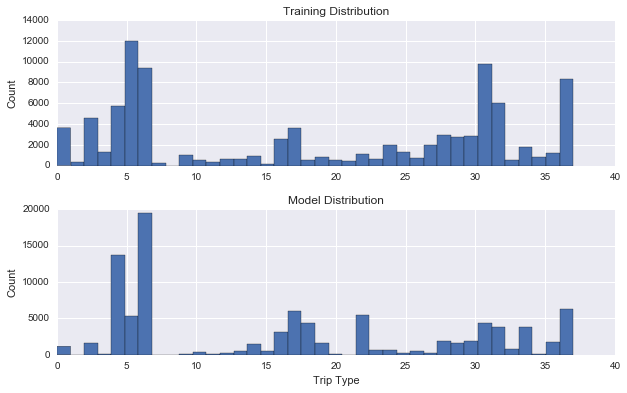

In [24]:
f, ax = plt.subplots(2,1, figsize=(10,6))

df.TripType.hist(bins=df.TripType.nunique(), ax=ax[0])
df_prediction.hist(bins=df.TripType.nunique(), ax=ax[1])
ax[0].set_title('Training Distribution')
ax[1].set_title('Model Distribution')
ax[1].set_xlabel('Trip Type')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.show()

In [ ]:
# Re-encode trip types
reEnc = tripEnc.inverse_transform( df_prediction.TripType.astype(int) )
cols = ["VisitNumber"] + [ "TripType_{}".format(i) for i in sorted(tripEnc.classes_) ]

tripEnc.classes_

new_df = pd.concat([ pd.DataFrame(columns=cols), pd.get_dummies(  reEnc, prefix="TripType")])
new_df = new_df.fillna(0)
new_df.VisitNumber = df_prediction.index.values
new_df = new_df.set_index('VisitNumber')
new_df = new_df[cols[1:]]
print(len(new_df.columns))
new_df.astype(int).to_csv('output.csv', )
new_df.iloc[0:10]